*Роботу виконав </br> Бірук Сергій </br> Група КІ-31мп*




In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score
import math
import numpy as np
from tqdm import tqdm, trange

In [2]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((28, 28)),
                                transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 12746375.28it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 187323.35it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3666490.03it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18008571.30it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

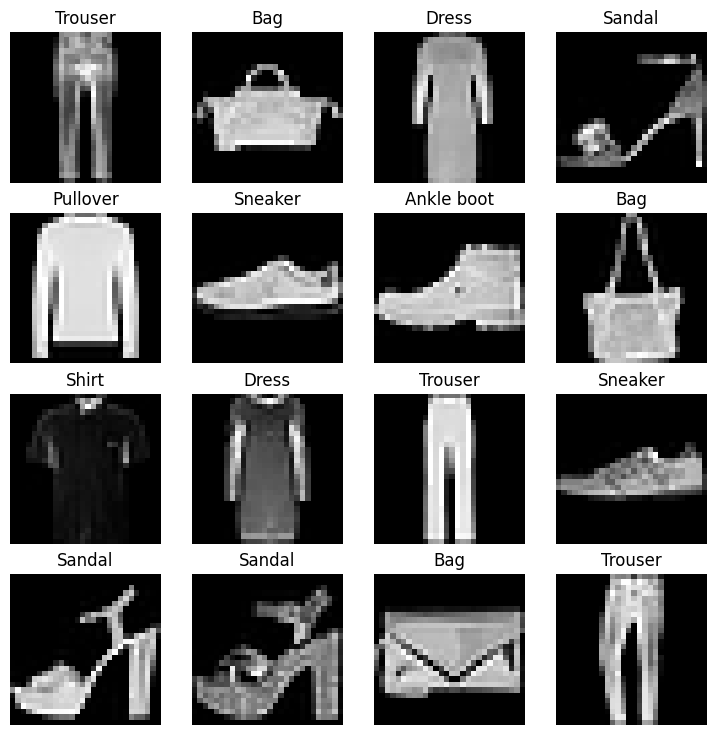

In [4]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [5]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader = torch.utils.data.DataLoader(val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(testset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 750 batches of 64
Length of valid dataloader: 188 batches of 64
Length of test dataloader: 157 batches of 64


In [6]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        batch_size, seq_length, token_dim = sequences.size()

        # Reshape the input sequences into (N, seq_length, n_heads, d_head)
        sequences = sequences.view(batch_size, seq_length, self.n_heads, self.d_head)

        result = []

        for head in range(self.n_heads):
            q_mapping = self.q_mappings[head]
            k_mapping = self.k_mappings[head]
            v_mapping = self.v_mappings[head]

            q = q_mapping(sequences[:, :, head, :])
            k = k_mapping(sequences[:, :, head, :])
            v = v_mapping(sequences[:, :, head, :])

            attention = self.softmax(torch.matmul(q, k.permute(0, 2, 1)) / (self.d_head**0.5))
            seq_result = torch.matmul(attention, v)

            result.append(seq_result)

        # Concatenate and reshape the result to (N, seq_length, item_dim)
        result = torch.cat(result, dim=2)

        return result



class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        # Multi-Head Self-Attention Layer
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)

        # MLP Layer
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        # Multi-Head Self-Attention
        out = x + self.mhsa(self.norm1(x))

        # MLP Layer
        out = out + self.mlp(self.norm2(out))
        return out


def get_positional_embeddings(sequence_length, d):
    # Create an array with positions from 0 to sequence_length - 1
    positions = torch.arange(0, sequence_length).unsqueeze(1)

    # Compute the angles for the even and odd dimensions
    angles = positions / torch.pow(10000, torch.arange(0, d, 2) / d)

    # Use sine for even dimensions and cosine for odd dimensions
    embeddings = torch.zeros(sequence_length, d)
    embeddings[:, 0::2] = torch.sin(angles)
    embeddings[:, 1::2] = torch.cos(angles)

    return embeddings

In [7]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        super(MyViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2, hidden_d),
            persistent=False,
        )

        # 3) Transformer encoder blocks
        self.transformer = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 4) Classification MLP
        self.mlp = nn.Sequential(nn.Linear(hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patch_size_h, patch_size_w = self.patch_size
        patches = images.unfold(2, patch_size_h, patch_size_h).unfold(3, patch_size_w, patch_size_w)
        patches = patches.contiguous().view(n, c, -1, patch_size_h, patch_size_w)
        patches = patches.permute(0, 2, 1, 3, 4).contiguous().view(n, -1, c * patch_size_h * patch_size_w)

        tokens = self.linear_mapper(patches)
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        for block in self.transformer:
            out = block(out)

        # add mean pooling here to replace the classification token
        out = torch.mean(out, dim=1)

        out = self.mlp(out)

        return out

In [8]:
N_EPOCHS = 100
LR = 0.005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

Using device:  cuda (Tesla T4)


In [9]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_precisions = []
val_precisions = []

# Training loop
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_predictions = []
    train_labels = []

    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        train_predictions.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_precision = precision_score(train_labels, train_predictions, average='macro', zero_division=0.0)

    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    train_precisions.append(train_precision)

    # Validation
    model.eval()
    correct_val = 0
    running_loss = 0.0
    total_val = 0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for data in valid_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(valid_dataloader)
        val_accuracy = 100 * correct_val / total_val
        val_precision = precision_score(val_labels, val_predictions, average='macro', zero_division=0.0)

        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        val_precisions.append(val_precision)

        print(f"Epoch [{epoch + 1}/{N_EPOCHS}] - "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.2f}% - "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation Precision: {val_precision:.2f}%")

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_dataloader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_dataloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Epoch 1 in training: 100%|██████████| 750/750 [00:18<00:00, 41.24it/s]


Epoch [1/100] - Train Loss: 1.9645, Train Accuracy: 49.71%, Train Precision: 0.42% - Validation Loss: 1.8658, Validation Accuracy: 59.65%, Validation Precision: 0.52%


Epoch 2 in training: 100%|██████████| 750/750 [00:16<00:00, 46.03it/s]


Epoch [2/100] - Train Loss: 1.8131, Train Accuracy: 64.97%, Train Precision: 0.61% - Validation Loss: 1.7583, Validation Accuracy: 70.51%, Validation Precision: 0.66%


Epoch 3 in training: 100%|██████████| 750/750 [00:15<00:00, 47.04it/s]


Epoch [3/100] - Train Loss: 1.7424, Train Accuracy: 71.98%, Train Precision: 0.66% - Validation Loss: 1.7492, Validation Accuracy: 71.43%, Validation Precision: 0.67%


Epoch 4 in training: 100%|██████████| 750/750 [00:17<00:00, 43.35it/s]


Epoch [4/100] - Train Loss: 1.7318, Train Accuracy: 72.95%, Train Precision: 0.67% - Validation Loss: 1.7289, Validation Accuracy: 73.33%, Validation Precision: 0.67%


Epoch 5 in training: 100%|██████████| 750/750 [00:15<00:00, 47.68it/s]


Epoch [5/100] - Train Loss: 1.7277, Train Accuracy: 73.36%, Train Precision: 0.68% - Validation Loss: 1.7205, Validation Accuracy: 74.23%, Validation Precision: 0.69%


Epoch 6 in training: 100%|██████████| 750/750 [00:17<00:00, 43.81it/s]


Epoch [6/100] - Train Loss: 1.7239, Train Accuracy: 73.71%, Train Precision: 0.68% - Validation Loss: 1.7149, Validation Accuracy: 74.65%, Validation Precision: 0.69%


Epoch 7 in training: 100%|██████████| 750/750 [00:15<00:00, 47.88it/s]


Epoch [7/100] - Train Loss: 1.7227, Train Accuracy: 73.85%, Train Precision: 0.68% - Validation Loss: 1.7343, Validation Accuracy: 72.79%, Validation Precision: 0.69%


Epoch 8 in training: 100%|██████████| 750/750 [00:16<00:00, 45.67it/s]


Epoch [8/100] - Train Loss: 1.7223, Train Accuracy: 73.88%, Train Precision: 0.68% - Validation Loss: 1.7205, Validation Accuracy: 74.03%, Validation Precision: 0.68%


Epoch 9 in training: 100%|██████████| 750/750 [00:15<00:00, 48.05it/s]


Epoch [9/100] - Train Loss: 1.7184, Train Accuracy: 74.29%, Train Precision: 0.69% - Validation Loss: 1.7115, Validation Accuracy: 74.97%, Validation Precision: 0.70%


Epoch 10 in training: 100%|██████████| 750/750 [00:16<00:00, 45.68it/s]


Epoch [10/100] - Train Loss: 1.7165, Train Accuracy: 74.47%, Train Precision: 0.69% - Validation Loss: 1.7171, Validation Accuracy: 74.39%, Validation Precision: 0.70%


Epoch 11 in training: 100%|██████████| 750/750 [00:15<00:00, 47.48it/s]


Epoch [11/100] - Train Loss: 1.7158, Train Accuracy: 74.49%, Train Precision: 0.69% - Validation Loss: 1.7250, Validation Accuracy: 73.58%, Validation Precision: 0.70%


Epoch 12 in training: 100%|██████████| 750/750 [00:16<00:00, 45.95it/s]


Epoch [12/100] - Train Loss: 1.7153, Train Accuracy: 74.55%, Train Precision: 0.69% - Validation Loss: 1.7162, Validation Accuracy: 74.51%, Validation Precision: 0.69%


Epoch 13 in training: 100%|██████████| 750/750 [00:15<00:00, 48.06it/s]


Epoch [13/100] - Train Loss: 1.7142, Train Accuracy: 74.65%, Train Precision: 0.69% - Validation Loss: 1.7158, Validation Accuracy: 74.47%, Validation Precision: 0.69%


Epoch 14 in training: 100%|██████████| 750/750 [00:16<00:00, 45.67it/s]


Epoch [14/100] - Train Loss: 1.7138, Train Accuracy: 74.66%, Train Precision: 0.69% - Validation Loss: 1.7095, Validation Accuracy: 75.06%, Validation Precision: 0.70%


Epoch 15 in training: 100%|██████████| 750/750 [00:15<00:00, 47.96it/s]


Epoch [15/100] - Train Loss: 1.7139, Train Accuracy: 74.67%, Train Precision: 0.69% - Validation Loss: 1.7055, Validation Accuracy: 75.56%, Validation Precision: 0.70%


Epoch 16 in training: 100%|██████████| 750/750 [00:16<00:00, 46.54it/s]


Epoch [16/100] - Train Loss: 1.7185, Train Accuracy: 74.19%, Train Precision: 0.69% - Validation Loss: 1.7227, Validation Accuracy: 73.89%, Validation Precision: 0.68%


Epoch 17 in training: 100%|██████████| 750/750 [00:15<00:00, 48.28it/s]


Epoch [17/100] - Train Loss: 1.7130, Train Accuracy: 74.79%, Train Precision: 0.69% - Validation Loss: 1.7040, Validation Accuracy: 75.63%, Validation Precision: 0.70%


Epoch 18 in training: 100%|██████████| 750/750 [00:15<00:00, 47.02it/s]


Epoch [18/100] - Train Loss: 1.7113, Train Accuracy: 74.88%, Train Precision: 0.69% - Validation Loss: 1.7178, Validation Accuracy: 74.25%, Validation Precision: 0.68%


Epoch 19 in training: 100%|██████████| 750/750 [00:15<00:00, 48.99it/s]


Epoch [19/100] - Train Loss: 1.7083, Train Accuracy: 75.19%, Train Precision: 0.69% - Validation Loss: 1.7257, Validation Accuracy: 73.42%, Validation Precision: 0.67%


Epoch 20 in training: 100%|██████████| 750/750 [00:15<00:00, 47.35it/s]


Epoch [20/100] - Train Loss: 1.7060, Train Accuracy: 75.47%, Train Precision: 0.70% - Validation Loss: 1.7185, Validation Accuracy: 74.24%, Validation Precision: 0.69%


Epoch 21 in training: 100%|██████████| 750/750 [00:15<00:00, 48.52it/s]


Epoch [21/100] - Train Loss: 1.7064, Train Accuracy: 75.39%, Train Precision: 0.69% - Validation Loss: 1.7040, Validation Accuracy: 75.63%, Validation Precision: 0.70%


Epoch 22 in training: 100%|██████████| 750/750 [00:15<00:00, 48.66it/s]


Epoch [22/100] - Train Loss: 1.7023, Train Accuracy: 75.86%, Train Precision: 0.70% - Validation Loss: 1.7075, Validation Accuracy: 75.29%, Validation Precision: 0.70%


Epoch 23 in training: 100%|██████████| 750/750 [00:15<00:00, 47.55it/s]


Epoch [23/100] - Train Loss: 1.7029, Train Accuracy: 75.74%, Train Precision: 0.70% - Validation Loss: 1.7069, Validation Accuracy: 75.30%, Validation Precision: 0.69%


Epoch 24 in training: 100%|██████████| 750/750 [00:15<00:00, 47.80it/s]


Epoch [24/100] - Train Loss: 1.7014, Train Accuracy: 75.94%, Train Precision: 0.70% - Validation Loss: 1.7246, Validation Accuracy: 73.61%, Validation Precision: 0.69%


Epoch 25 in training: 100%|██████████| 750/750 [00:15<00:00, 47.34it/s]


Epoch [25/100] - Train Loss: 1.7003, Train Accuracy: 76.08%, Train Precision: 0.70% - Validation Loss: 1.7084, Validation Accuracy: 75.27%, Validation Precision: 0.70%


Epoch 26 in training: 100%|██████████| 750/750 [00:15<00:00, 48.22it/s]


Epoch [26/100] - Train Loss: 1.6999, Train Accuracy: 76.05%, Train Precision: 0.70% - Validation Loss: 1.7141, Validation Accuracy: 74.54%, Validation Precision: 0.70%


Epoch 27 in training: 100%|██████████| 750/750 [00:15<00:00, 48.19it/s]


Epoch [27/100] - Train Loss: 1.7016, Train Accuracy: 75.87%, Train Precision: 0.70% - Validation Loss: 1.7060, Validation Accuracy: 75.36%, Validation Precision: 0.70%


Epoch 28 in training: 100%|██████████| 750/750 [00:15<00:00, 48.32it/s]


Epoch [28/100] - Train Loss: 1.7027, Train Accuracy: 75.78%, Train Precision: 0.70% - Validation Loss: 1.6965, Validation Accuracy: 76.45%, Validation Precision: 0.70%


Epoch 29 in training: 100%|██████████| 750/750 [00:15<00:00, 48.26it/s]


Epoch [29/100] - Train Loss: 1.6997, Train Accuracy: 76.08%, Train Precision: 0.70% - Validation Loss: 1.6990, Validation Accuracy: 76.16%, Validation Precision: 0.70%


Epoch 30 in training: 100%|██████████| 750/750 [00:15<00:00, 47.60it/s]


Epoch [30/100] - Train Loss: 1.7000, Train Accuracy: 76.05%, Train Precision: 0.70% - Validation Loss: 1.7151, Validation Accuracy: 74.46%, Validation Precision: 0.69%


Epoch 31 in training: 100%|██████████| 750/750 [00:15<00:00, 47.89it/s]


Epoch [31/100] - Train Loss: 1.6988, Train Accuracy: 76.15%, Train Precision: 0.70% - Validation Loss: 1.7102, Validation Accuracy: 75.22%, Validation Precision: 0.71%


Epoch 32 in training: 100%|██████████| 750/750 [00:15<00:00, 48.72it/s]


Epoch [32/100] - Train Loss: 1.7012, Train Accuracy: 75.90%, Train Precision: 0.70% - Validation Loss: 1.7370, Validation Accuracy: 72.35%, Validation Precision: 0.70%


Epoch 33 in training: 100%|██████████| 750/750 [00:16<00:00, 44.94it/s]


Epoch [33/100] - Train Loss: 1.6994, Train Accuracy: 76.11%, Train Precision: 0.70% - Validation Loss: 1.6923, Validation Accuracy: 76.83%, Validation Precision: 0.71%


Epoch 34 in training: 100%|██████████| 750/750 [00:15<00:00, 48.16it/s]


Epoch [34/100] - Train Loss: 1.6983, Train Accuracy: 76.19%, Train Precision: 0.70% - Validation Loss: 1.7061, Validation Accuracy: 75.38%, Validation Precision: 0.70%


Epoch 35 in training: 100%|██████████| 750/750 [00:15<00:00, 47.13it/s]


Epoch [35/100] - Train Loss: 1.6955, Train Accuracy: 76.47%, Train Precision: 0.70% - Validation Loss: 1.6944, Validation Accuracy: 76.58%, Validation Precision: 0.70%


Epoch 36 in training: 100%|██████████| 750/750 [00:15<00:00, 48.09it/s]


Epoch [36/100] - Train Loss: 1.7004, Train Accuracy: 75.97%, Train Precision: 0.70% - Validation Loss: 1.6972, Validation Accuracy: 76.33%, Validation Precision: 0.71%


Epoch 37 in training: 100%|██████████| 750/750 [00:15<00:00, 47.20it/s]


Epoch [37/100] - Train Loss: 1.6949, Train Accuracy: 76.58%, Train Precision: 0.71% - Validation Loss: 1.6939, Validation Accuracy: 76.76%, Validation Precision: 0.71%


Epoch 38 in training: 100%|██████████| 750/750 [00:15<00:00, 48.11it/s]


Epoch [38/100] - Train Loss: 1.6942, Train Accuracy: 76.65%, Train Precision: 0.71% - Validation Loss: 1.7018, Validation Accuracy: 75.89%, Validation Precision: 0.71%


Epoch 39 in training: 100%|██████████| 750/750 [00:15<00:00, 47.16it/s]


Epoch [39/100] - Train Loss: 1.6965, Train Accuracy: 76.40%, Train Precision: 0.70% - Validation Loss: 1.6972, Validation Accuracy: 76.27%, Validation Precision: 0.71%


Epoch 40 in training: 100%|██████████| 750/750 [00:15<00:00, 48.19it/s]


Epoch [40/100] - Train Loss: 1.6959, Train Accuracy: 76.45%, Train Precision: 0.71% - Validation Loss: 1.6894, Validation Accuracy: 77.08%, Validation Precision: 0.71%


Epoch 41 in training: 100%|██████████| 750/750 [00:16<00:00, 46.36it/s]


Epoch [41/100] - Train Loss: 1.6926, Train Accuracy: 76.72%, Train Precision: 0.71% - Validation Loss: 1.6899, Validation Accuracy: 77.06%, Validation Precision: 0.71%


Epoch 42 in training: 100%|██████████| 750/750 [00:15<00:00, 47.51it/s]


Epoch [42/100] - Train Loss: 1.6942, Train Accuracy: 76.60%, Train Precision: 0.71% - Validation Loss: 1.6934, Validation Accuracy: 76.67%, Validation Precision: 0.71%


Epoch 43 in training: 100%|██████████| 750/750 [00:16<00:00, 46.16it/s]


Epoch [43/100] - Train Loss: 1.6957, Train Accuracy: 76.48%, Train Precision: 0.70% - Validation Loss: 1.7216, Validation Accuracy: 73.92%, Validation Precision: 0.69%


Epoch 44 in training: 100%|██████████| 750/750 [00:15<00:00, 48.25it/s]


Epoch [44/100] - Train Loss: 1.6941, Train Accuracy: 76.62%, Train Precision: 0.71% - Validation Loss: 1.6887, Validation Accuracy: 77.25%, Validation Precision: 0.72%


Epoch 45 in training: 100%|██████████| 750/750 [00:16<00:00, 46.39it/s]


Epoch [45/100] - Train Loss: 1.6918, Train Accuracy: 76.84%, Train Precision: 0.71% - Validation Loss: 1.7078, Validation Accuracy: 75.17%, Validation Precision: 0.69%


Epoch 46 in training: 100%|██████████| 750/750 [00:16<00:00, 45.98it/s]


Epoch [46/100] - Train Loss: 1.6972, Train Accuracy: 76.32%, Train Precision: 0.70% - Validation Loss: 1.6968, Validation Accuracy: 76.33%, Validation Precision: 0.70%


Epoch 47 in training: 100%|██████████| 750/750 [00:19<00:00, 38.58it/s]


Epoch [47/100] - Train Loss: 1.6935, Train Accuracy: 76.67%, Train Precision: 0.71% - Validation Loss: 1.6961, Validation Accuracy: 76.46%, Validation Precision: 0.71%


Epoch 48 in training: 100%|██████████| 750/750 [00:15<00:00, 47.69it/s]


Epoch [48/100] - Train Loss: 1.6951, Train Accuracy: 76.53%, Train Precision: 0.70% - Validation Loss: 1.7112, Validation Accuracy: 74.88%, Validation Precision: 0.70%


Epoch 49 in training: 100%|██████████| 750/750 [00:15<00:00, 47.87it/s]


Epoch [49/100] - Train Loss: 1.6901, Train Accuracy: 77.07%, Train Precision: 0.71% - Validation Loss: 1.6975, Validation Accuracy: 76.38%, Validation Precision: 0.71%


Epoch 50 in training: 100%|██████████| 750/750 [00:15<00:00, 48.13it/s]


Epoch [50/100] - Train Loss: 1.6908, Train Accuracy: 76.96%, Train Precision: 0.71% - Validation Loss: 1.6973, Validation Accuracy: 76.26%, Validation Precision: 0.71%


Epoch 51 in training: 100%|██████████| 750/750 [00:15<00:00, 47.73it/s]


Epoch [51/100] - Train Loss: 1.6931, Train Accuracy: 76.71%, Train Precision: 0.71% - Validation Loss: 1.6992, Validation Accuracy: 76.08%, Validation Precision: 0.71%


Epoch 52 in training: 100%|██████████| 750/750 [00:15<00:00, 47.73it/s]


Epoch [52/100] - Train Loss: 1.6886, Train Accuracy: 77.16%, Train Precision: 0.71% - Validation Loss: 1.6948, Validation Accuracy: 76.56%, Validation Precision: 0.71%


Epoch 53 in training: 100%|██████████| 750/750 [00:15<00:00, 48.12it/s]


Epoch [53/100] - Train Loss: 1.6908, Train Accuracy: 76.94%, Train Precision: 0.71% - Validation Loss: 1.7110, Validation Accuracy: 74.97%, Validation Precision: 0.71%


Epoch 54 in training: 100%|██████████| 750/750 [00:15<00:00, 48.71it/s]


Epoch [54/100] - Train Loss: 1.6938, Train Accuracy: 76.68%, Train Precision: 0.71% - Validation Loss: 1.6921, Validation Accuracy: 76.83%, Validation Precision: 0.71%


Epoch 55 in training: 100%|██████████| 750/750 [00:15<00:00, 47.99it/s]


Epoch [55/100] - Train Loss: 1.6893, Train Accuracy: 77.14%, Train Precision: 0.71% - Validation Loss: 1.6925, Validation Accuracy: 76.80%, Validation Precision: 0.71%


Epoch 56 in training: 100%|██████████| 750/750 [00:15<00:00, 47.66it/s]


Epoch [56/100] - Train Loss: 1.6901, Train Accuracy: 77.03%, Train Precision: 0.71% - Validation Loss: 1.6881, Validation Accuracy: 77.26%, Validation Precision: 0.71%


Epoch 57 in training: 100%|██████████| 750/750 [00:15<00:00, 48.08it/s]


Epoch [57/100] - Train Loss: 1.6903, Train Accuracy: 77.01%, Train Precision: 0.71% - Validation Loss: 1.7095, Validation Accuracy: 75.14%, Validation Precision: 0.70%


Epoch 58 in training: 100%|██████████| 750/750 [00:16<00:00, 46.36it/s]


Epoch [58/100] - Train Loss: 1.6907, Train Accuracy: 76.99%, Train Precision: 0.71% - Validation Loss: 1.7010, Validation Accuracy: 75.93%, Validation Precision: 0.71%


Epoch 59 in training: 100%|██████████| 750/750 [00:15<00:00, 47.91it/s]


Epoch [59/100] - Train Loss: 1.6920, Train Accuracy: 76.85%, Train Precision: 0.71% - Validation Loss: 1.6998, Validation Accuracy: 76.12%, Validation Precision: 0.71%


Epoch 60 in training: 100%|██████████| 750/750 [00:16<00:00, 46.48it/s]


Epoch [60/100] - Train Loss: 1.6934, Train Accuracy: 76.69%, Train Precision: 0.71% - Validation Loss: 1.6992, Validation Accuracy: 76.12%, Validation Precision: 0.71%


Epoch 61 in training: 100%|██████████| 750/750 [00:15<00:00, 47.97it/s]


Epoch [61/100] - Train Loss: 1.6914, Train Accuracy: 76.92%, Train Precision: 0.71% - Validation Loss: 1.7095, Validation Accuracy: 75.12%, Validation Precision: 0.70%


Epoch 62 in training: 100%|██████████| 750/750 [00:15<00:00, 47.35it/s]


Epoch [62/100] - Train Loss: 1.6966, Train Accuracy: 76.38%, Train Precision: 0.70% - Validation Loss: 1.6997, Validation Accuracy: 76.03%, Validation Precision: 0.71%


Epoch 63 in training: 100%|██████████| 750/750 [00:15<00:00, 47.97it/s]


Epoch [63/100] - Train Loss: 1.6869, Train Accuracy: 77.36%, Train Precision: 0.71% - Validation Loss: 1.6934, Validation Accuracy: 76.83%, Validation Precision: 0.71%


Epoch 64 in training: 100%|██████████| 750/750 [00:16<00:00, 46.59it/s]


Epoch [64/100] - Train Loss: 1.6881, Train Accuracy: 77.25%, Train Precision: 0.71% - Validation Loss: 1.6899, Validation Accuracy: 77.02%, Validation Precision: 0.71%


Epoch 65 in training: 100%|██████████| 750/750 [00:15<00:00, 48.87it/s]


Epoch [65/100] - Train Loss: 1.6916, Train Accuracy: 76.86%, Train Precision: 0.71% - Validation Loss: 1.6907, Validation Accuracy: 77.05%, Validation Precision: 0.71%


Epoch 66 in training: 100%|██████████| 750/750 [00:16<00:00, 46.60it/s]


Epoch [66/100] - Train Loss: 1.6979, Train Accuracy: 76.26%, Train Precision: 0.70% - Validation Loss: 1.6875, Validation Accuracy: 77.36%, Validation Precision: 0.72%


Epoch 67 in training: 100%|██████████| 750/750 [00:15<00:00, 48.43it/s]


Epoch [67/100] - Train Loss: 1.6883, Train Accuracy: 77.23%, Train Precision: 0.71% - Validation Loss: 1.7012, Validation Accuracy: 75.92%, Validation Precision: 0.70%


Epoch 68 in training: 100%|██████████| 750/750 [00:16<00:00, 45.95it/s]


Epoch [68/100] - Train Loss: 1.6905, Train Accuracy: 77.00%, Train Precision: 0.71% - Validation Loss: 1.6878, Validation Accuracy: 77.30%, Validation Precision: 0.72%


Epoch 69 in training: 100%|██████████| 750/750 [00:15<00:00, 48.07it/s]


Epoch [69/100] - Train Loss: 1.6904, Train Accuracy: 77.00%, Train Precision: 0.71% - Validation Loss: 1.6961, Validation Accuracy: 76.42%, Validation Precision: 0.71%


Epoch 70 in training: 100%|██████████| 750/750 [00:16<00:00, 45.17it/s]


Epoch [70/100] - Train Loss: 1.6884, Train Accuracy: 77.20%, Train Precision: 0.71% - Validation Loss: 1.7036, Validation Accuracy: 75.72%, Validation Precision: 0.70%


Epoch 71 in training: 100%|██████████| 750/750 [00:15<00:00, 48.14it/s]


Epoch [71/100] - Train Loss: 1.6922, Train Accuracy: 76.84%, Train Precision: 0.71% - Validation Loss: 1.6978, Validation Accuracy: 76.20%, Validation Precision: 0.70%


Epoch 72 in training: 100%|██████████| 750/750 [00:16<00:00, 45.81it/s]


Epoch [72/100] - Train Loss: 1.6901, Train Accuracy: 77.02%, Train Precision: 0.71% - Validation Loss: 1.6932, Validation Accuracy: 76.71%, Validation Precision: 0.71%


Epoch 73 in training: 100%|██████████| 750/750 [00:15<00:00, 47.51it/s]


Epoch [73/100] - Train Loss: 1.6895, Train Accuracy: 77.07%, Train Precision: 0.71% - Validation Loss: 1.6918, Validation Accuracy: 76.90%, Validation Precision: 0.71%


Epoch 74 in training: 100%|██████████| 750/750 [00:16<00:00, 45.34it/s]


Epoch [74/100] - Train Loss: 1.6896, Train Accuracy: 77.10%, Train Precision: 0.71% - Validation Loss: 1.6829, Validation Accuracy: 77.78%, Validation Precision: 0.72%


Epoch 75 in training: 100%|██████████| 750/750 [00:15<00:00, 47.87it/s]


Epoch [75/100] - Train Loss: 1.6910, Train Accuracy: 76.94%, Train Precision: 0.71% - Validation Loss: 1.6934, Validation Accuracy: 76.78%, Validation Precision: 0.71%


Epoch 76 in training: 100%|██████████| 750/750 [00:16<00:00, 45.73it/s]


Epoch [76/100] - Train Loss: 1.6908, Train Accuracy: 76.94%, Train Precision: 0.71% - Validation Loss: 1.6901, Validation Accuracy: 77.04%, Validation Precision: 0.71%


Epoch 77 in training: 100%|██████████| 750/750 [00:15<00:00, 47.90it/s]


Epoch [77/100] - Train Loss: 1.6914, Train Accuracy: 76.93%, Train Precision: 0.71% - Validation Loss: 1.6868, Validation Accuracy: 77.40%, Validation Precision: 0.72%


Epoch 78 in training: 100%|██████████| 750/750 [00:16<00:00, 45.89it/s]


Epoch [78/100] - Train Loss: 1.6944, Train Accuracy: 76.63%, Train Precision: 0.71% - Validation Loss: 1.7292, Validation Accuracy: 73.13%, Validation Precision: 0.69%


Epoch 79 in training: 100%|██████████| 750/750 [00:15<00:00, 48.63it/s]


Epoch [79/100] - Train Loss: 1.6925, Train Accuracy: 76.79%, Train Precision: 0.71% - Validation Loss: 1.6876, Validation Accuracy: 77.30%, Validation Precision: 0.72%


Epoch 80 in training: 100%|██████████| 750/750 [00:16<00:00, 46.36it/s]


Epoch [80/100] - Train Loss: 1.6884, Train Accuracy: 77.21%, Train Precision: 0.71% - Validation Loss: 1.6956, Validation Accuracy: 76.49%, Validation Precision: 0.71%


Epoch 81 in training: 100%|██████████| 750/750 [00:15<00:00, 48.62it/s]


Epoch [81/100] - Train Loss: 1.6889, Train Accuracy: 77.20%, Train Precision: 0.71% - Validation Loss: 1.7076, Validation Accuracy: 75.31%, Validation Precision: 0.71%


Epoch 82 in training: 100%|██████████| 750/750 [00:16<00:00, 46.68it/s]


Epoch [82/100] - Train Loss: 1.6927, Train Accuracy: 76.81%, Train Precision: 0.71% - Validation Loss: 1.6868, Validation Accuracy: 77.34%, Validation Precision: 0.72%


Epoch 83 in training: 100%|██████████| 750/750 [00:15<00:00, 48.36it/s]


Epoch [83/100] - Train Loss: 1.6943, Train Accuracy: 76.63%, Train Precision: 0.70% - Validation Loss: 1.6941, Validation Accuracy: 76.64%, Validation Precision: 0.71%


Epoch 84 in training: 100%|██████████| 750/750 [00:16<00:00, 46.58it/s]


Epoch [84/100] - Train Loss: 1.6922, Train Accuracy: 76.86%, Train Precision: 0.71% - Validation Loss: 1.7098, Validation Accuracy: 75.06%, Validation Precision: 0.70%


Epoch 85 in training: 100%|██████████| 750/750 [00:15<00:00, 47.81it/s]


Epoch [85/100] - Train Loss: 1.6943, Train Accuracy: 76.62%, Train Precision: 0.70% - Validation Loss: 1.7050, Validation Accuracy: 75.45%, Validation Precision: 0.69%


Epoch 86 in training: 100%|██████████| 750/750 [00:16<00:00, 46.46it/s]


Epoch [86/100] - Train Loss: 1.6897, Train Accuracy: 77.08%, Train Precision: 0.71% - Validation Loss: 1.6912, Validation Accuracy: 76.90%, Validation Precision: 0.71%


Epoch 87 in training: 100%|██████████| 750/750 [00:15<00:00, 48.07it/s]


Epoch [87/100] - Train Loss: 1.6943, Train Accuracy: 76.62%, Train Precision: 0.70% - Validation Loss: 1.6796, Validation Accuracy: 78.10%, Validation Precision: 0.72%


Epoch 88 in training: 100%|██████████| 750/750 [00:15<00:00, 47.41it/s]


Epoch [88/100] - Train Loss: 1.6905, Train Accuracy: 77.03%, Train Precision: 0.71% - Validation Loss: 1.7068, Validation Accuracy: 75.41%, Validation Precision: 0.70%


Epoch 89 in training: 100%|██████████| 750/750 [00:15<00:00, 47.73it/s]


Epoch [89/100] - Train Loss: 1.6897, Train Accuracy: 77.09%, Train Precision: 0.71% - Validation Loss: 1.7103, Validation Accuracy: 75.04%, Validation Precision: 0.70%


Epoch 90 in training: 100%|██████████| 750/750 [00:15<00:00, 48.15it/s]


Epoch [90/100] - Train Loss: 1.6893, Train Accuracy: 77.12%, Train Precision: 0.71% - Validation Loss: 1.7045, Validation Accuracy: 75.61%, Validation Precision: 0.70%


Epoch 91 in training: 100%|██████████| 750/750 [00:15<00:00, 48.17it/s]


Epoch [91/100] - Train Loss: 1.6911, Train Accuracy: 76.93%, Train Precision: 0.71% - Validation Loss: 1.6863, Validation Accuracy: 77.43%, Validation Precision: 0.72%


Epoch 92 in training: 100%|██████████| 750/750 [00:15<00:00, 48.27it/s]


Epoch [92/100] - Train Loss: 1.6916, Train Accuracy: 76.90%, Train Precision: 0.71% - Validation Loss: 1.7227, Validation Accuracy: 73.79%, Validation Precision: 0.70%


Epoch 93 in training: 100%|██████████| 750/750 [00:17<00:00, 41.70it/s]


Epoch [93/100] - Train Loss: 1.6931, Train Accuracy: 76.74%, Train Precision: 0.71% - Validation Loss: 1.7039, Validation Accuracy: 75.66%, Validation Precision: 0.71%


Epoch 94 in training: 100%|██████████| 750/750 [00:16<00:00, 45.73it/s]


Epoch [94/100] - Train Loss: 1.6947, Train Accuracy: 76.60%, Train Precision: 0.71% - Validation Loss: 1.6851, Validation Accuracy: 77.59%, Validation Precision: 0.72%


Epoch 95 in training: 100%|██████████| 750/750 [00:15<00:00, 48.30it/s]


Epoch [95/100] - Train Loss: 1.6899, Train Accuracy: 77.09%, Train Precision: 0.71% - Validation Loss: 1.6999, Validation Accuracy: 76.11%, Validation Precision: 0.71%


Epoch 96 in training: 100%|██████████| 750/750 [00:16<00:00, 46.69it/s]


Epoch [96/100] - Train Loss: 1.6870, Train Accuracy: 77.38%, Train Precision: 0.71% - Validation Loss: 1.7023, Validation Accuracy: 75.78%, Validation Precision: 0.70%


Epoch 97 in training: 100%|██████████| 750/750 [00:15<00:00, 48.40it/s]


Epoch [97/100] - Train Loss: 1.6887, Train Accuracy: 77.20%, Train Precision: 0.71% - Validation Loss: 1.6966, Validation Accuracy: 76.40%, Validation Precision: 0.71%


Epoch 98 in training: 100%|██████████| 750/750 [00:17<00:00, 43.92it/s]


Epoch [98/100] - Train Loss: 1.6893, Train Accuracy: 77.15%, Train Precision: 0.71% - Validation Loss: 1.6999, Validation Accuracy: 76.10%, Validation Precision: 0.71%


Epoch 99 in training: 100%|██████████| 750/750 [00:15<00:00, 47.86it/s]


Epoch [99/100] - Train Loss: 1.6940, Train Accuracy: 76.68%, Train Precision: 0.71% - Validation Loss: 1.6850, Validation Accuracy: 77.63%, Validation Precision: 0.72%


Epoch 100 in training: 100%|██████████| 750/750 [00:16<00:00, 46.47it/s]


Epoch [100/100] - Train Loss: 1.6904, Train Accuracy: 77.03%, Train Precision: 0.71% - Validation Loss: 1.6975, Validation Accuracy: 76.32%, Validation Precision: 0.71%


Testing: 100%|██████████| 157/157 [00:02<00:00, 78.40it/s]

Test loss: 1.70
Test accuracy: 76.37%


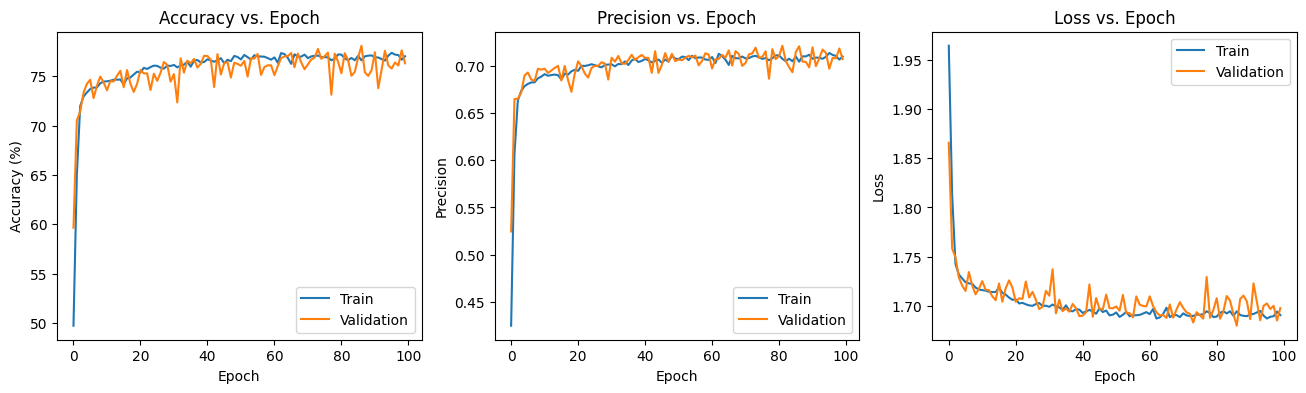

In [10]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_precisions, label='Train')
plt.plot(val_precisions, label='Validation')
plt.title('Precision vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

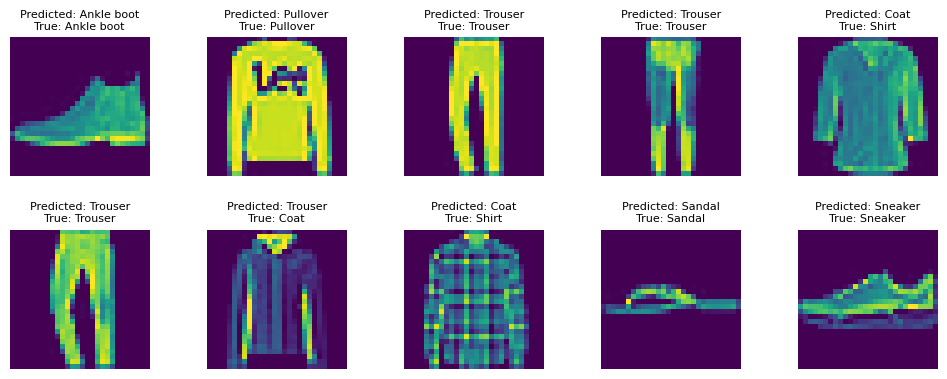

In [11]:
# Select a few random images from the test set
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)

# Visualize the images and their predicted labels
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
for i in range(2):
    for j in range(5):
        idx = i * 5 + j

        axs[i, j].imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
        axs[i, j].set_title(f'Predicted: {class_names[outputs[idx].argmax()]}\nTrue: {class_names[labels[idx]]}', fontsize=8)
        axs[i, j].axis('off')
plt.show()

У цій роботі ми реалізували модель Vision Transformer (ViT) для класифікації зображень. Архітектура моделі є гнучкою і може бути додатково налаштована та налаштована для конкретних наборів даних і програм. На завершення ця робота демонструє успішну реалізацію моделі Vision Transformer для класифікації зображень, демонструючи її потенціал для досягнення конкурентоспроможних результатів у різних завданнях, заснованих на зображенні. Проте порівнюючи результати із попередніх  лабораторних робіт при використані згорткових нейроних мереж ми отримували кращмй результат.